### Assignment 03

#### 1.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.3033
Epoch 2/10, Loss: 2.3033
Epoch 3/10, Loss: 2.3023
Epoch 4/10, Loss: 2.2626
Epoch 5/10, Loss: 2.1554
Epoch 6/10, Loss: 2.0968
Epoch 7/10, Loss: 2.0694
Epoch 8/10, Loss: 2.0450
Epoch 9/10, Loss: 2.0125
Epoch 10/10, Loss: 1.9821


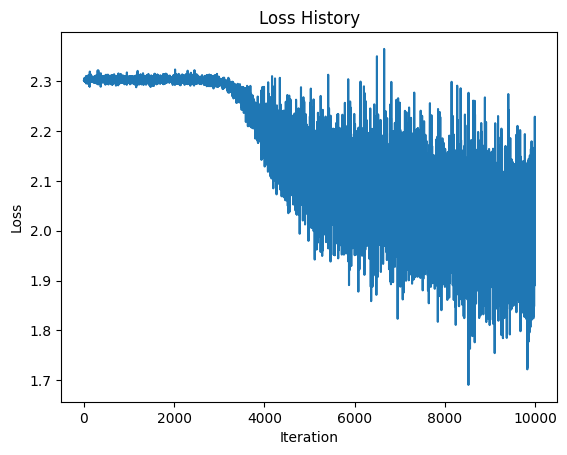

Training Accuracy: 27.24%
Test Accuracy: 27.29%


In [5]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Dataloading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Hidden layer size
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w1 = torch.randn(Din, H) * std
b1 = torch.zeros(H)
w2 = torch.randn(H, K) * std
b2 = torch.zeros(K)

# Hyperparameters
epochs = 10
lr = 0.005  # Learning rate
loss_history = []

# 3. Training Loop
for epoch in range(epochs):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)

        # Forward pass
        z1 = x_train.mm(w1) + b1  # First layer pre-activation
        a1 = torch.sigmoid(z1)  # Sigmoid activation
        z2 = a1.mm(w2) + b2  # Second layer pre-activation (output layer)

        # Compute cross-entropy loss
        y_pred = F.log_softmax(z2, dim=1)  # Log-softmax for numerical stability
        loss = F.nll_loss(y_pred, labels)  # Cross-entropy loss
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dz2 = F.softmax(z2, dim=1)
        dz2[range(Ntr), labels] -= 1  # Subtract 1 for correct class
        dz2 /= Ntr

        dw2 = a1.t().mm(dz2)
        db2 = dz2.sum(dim=0)

        da1 = dz2.mm(w2.t())
        dz1 = da1 * a1 * (1 - a1)  # Derivative of sigmoid

        dw1 = x_train.t().mm(dz1)
        db1 = dz1.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader):.4f}")

# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 5. Calculate Accuracy
def calculate_accuracy(loader, w1, b1, w2, b2):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            N = inputs.shape[0]
            x = inputs.view(N, -1)

            # Forward pass
            z1 = x.mm(w1) + b1
            a1 = torch.sigmoid(z1)
            z2 = a1.mm(w2) + b2
            y_pred = torch.argmax(z2, dim=1)

            total += labels.size(0)
            correct += (y_pred == labels).sum().item()
    return 100 * correct / total

train_acc = calculate_accuracy(trainloader, w1, b1, w2, b2)
test_acc = calculate_accuracy(testloader, w1, b1, w2, b2)

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

#### 2. LeNet-5 network for MNIST using Pytorch

In [ ]:
import torch
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testset = datasets.MNIST('./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LeNet-5
class LeNet5(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        '''
        One forward pass through the network.
        
        Args:
            x: input
        '''
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

model = LeNet5().to(device)

# Training and evaluation
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses = []

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Record average loss for this epoch
    train_losses.append(running_loss / len(trainloader))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_losses[-1]:.4f}")

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Calculate training accuracy
model.eval()
correct_train = sum((torch.max(model(inputs.to(device)), 1)[1] == labels.to(device)).sum().item()
                    for inputs, labels in trainloader)
train_accuracy = 100 * correct_train / len(trainloader.dataset)
print(f"Training accuracy: {train_accuracy:.2f}%")

# Calculate test accuracy
correct_test = sum((torch.max(model(inputs.to(device)), 1)[1] == labels.to(device)).sum().item()
                   for inputs, labels in testloader)
test_accuracy = 100 * correct_test / len(testloader.dataset)
print(f"Test accuracy: {test_accuracy:.2f}%")


AttributeError: 'LeNet5' object has no attribute 'num_flat_features'